In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

### Introduction

In this first part we will define our working environment. The plan of our house can be found below. The objective of this study case is the nalysis of a cubic building with 5 identical walls & a transparent wall (glass window), air infiltration, and HVAC system controlling the indoor air temperature.

### Design model

The room that we will study is presented in the figure below. Two rooms are separated by a small wall without insulation. The total area of the model is about 9 meters square and the ceiling is 3 meters high. The rooms have each 3 exterior walls and one interior wall. We will consider the house as insulated from the outside .
The interior walls are made of concrete. The room also has a 1 m² window, a 2 m² door and a HVAC device.



<center><img src="https://hub.gke2.mybinder.org/user/cghiaus-dm4bem-19y1e1gf/files/Sch%C3%A9ma%20maison.png?_xsrf=2%7C3ce45c22%7Cea41507d6477cef712308b01cb5ff2db%7C1682345682"></center>

> Figure 1. Plan of the building



We will now define boundary conditions wich are important to solve our case.


### Hypothesis

Boundary Conditions:

- Temperature of the exterior air = 10 °C
- Setpoint temperature of the interior air = 20°C
- Unique temperature on each wall
- Unidirectionnal heat transfer

### Dimension of windows, doors, and walls.

In [3]:
l = 3               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls
Sc1=2*Sg
Sc2=3*Sg

Thermo-physical properties
The thermophysical properties of the air (in SI units) are:

In [4]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat in': 1000,
        'Specific heat out' : 25}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat in,Specific heat out
Air,1.2,1000,25


We use concrete, glass and insulation (glass wool) as materials. We take our door with oak wood. 

In [5]:
BETON = {'Conductivity': 1.400,
            'Density': 2400.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 60}

ISOLANT = {'Conductivity': 0.046,
              'Density': 25.0,
              'Specific heat': 1030,
              'Width': 0.08,
              'Surface':45}

VERRE = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': 40}

PORTE = {'Conductivity': 0.15,
         'Density': 800,
         'Specific heat': 2000,
         'Width': 0.1,
         'Surface': 4}

wall = pd.DataFrame.from_dict({'Layer_out (insulation)': ISOLANT,
                               'Layer_in (concrete)': BETON,
                               'Glass': VERRE,
                               'Door': PORTE},
                              orient='index')


### Thermal circuit

We will now able to draw our thermal circuit. The objective with this one will be to computerize our model. The figure will be found below.

<center><img src="https://hub.gke2.mybinder.org/user/cghiaus-dm4bem-19y1e1gf/files/Sch%C3%A9ma%20%C3%A9lec.png?_xsrf=2%7C3ce45c22%7Cea41507d6477cef712308b01cb5ff2db%7C1682345682"></center>

>Figure 2. Thermal circuit


### Convection coefficients

Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [6]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
# h = pd.DataFrame([{'in': 8., 'out': 25}])  # W/(m²⋅K)


### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [7]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Door,6.000
Glass,1400.000
Layer_in (concrete),420.000
Layer_out (insulation),25.875


#### Convection
The conductances 0, 6 and 7 model the heat transfer by [convection]. Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient], W/(m²⋅K);
- $S$ - surface area of the wall, m². 

In [8]:
# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass

### Coding section

Creating the code 

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

θ = [10.00513608 14.61323793 19.22133977 19.59986243 19.97838508 19.98156329
 19.99931665 10.00924048 19.9679881  19.93665955 19.54023079 19.16958601
 14.6573887  10.14519139 10.00097744 19.89756193 19.91087557] °C
As = 
 [[-6.50686408e-07  3.12531253e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.40840783e-05 -8.66466682e-04  8.02153489e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  7.82403498e-06 -4.80226170e-03  3.38203463e-07
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.12734488e-07 -2.25268456e-07
   6.84700783e-09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.84700783e-09
  -3.92820130e-06  3.12531253e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.40840783e-05 -1.33038182e-04]] 

Bs = 
 [[3.38155155e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.87863975e-11
  0.00000000e+00 0.00000000e+00 0.0000

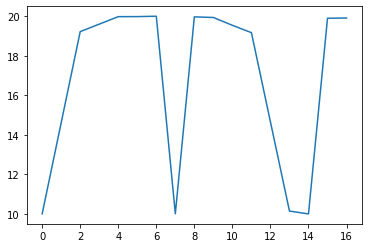

In [9]:
#Initial Values#

Text = 10                        #°C
Tvent = 20                      #°C
Tint1 = 20                      #°C
Tint2 = 20                      #°C
lambda_concrete = 1.4
lambda_insulation = 0.046
lambda_glass = 1.4
lambda_wood = 0.15
hi = 8
ho = 25


Swall = 9
Swindow = 1
Sdoor = 2
Sint = Swall*8 - Swindow - Sdoor

import numpy as np
A= np.zeros((24,17))
A[0, 0] = 1
A[1, 1] = 1
A[1, 0] = -1
A[2, 2] = 1
A[2, 1] = -1
A[3, 3] = 1
A[3, 2] = -1
A[4, 4] = 1
A[4, 3] = -1
A[6, 6] = 1
A[6, 4] = -1
A[5, 5] = 1
A[5, 4] = -1
A[8, 7] = 1
A[9, 5] = 1
A[9, 7] = -1
A[7, 6] = 1
A[7, 5] = -1
A[10, 6] = 1
A[11, 6] = 1
A[12, 6] = 1
A[12, 8] = -1
A[13, 8] = 1
A[13, 9] = -1
A[14, 16] = 1
A[14, 10] = -1
A[15, 10] = 1
A[15, 11] = -1
A[16, 11] = 1
A[16, 12] = -1
A[17, 12] = 1
A[17, 13] = -1
A[18, 13] = 1
A[19, 15] = 1
A[19, 14] = -1
A[20, 14] = 1
A[21, 9] = 1
A[23, 9] = 1
A[23, 16] = -1
A[22, 9] = 1
A[22, 15] = -1

B=np.zeros(24)
B[0]=1
B[8]=1
B[10]=1
B[11]=1
B[18]=1
B[20]=1
B[21]=1

G=np.zeros((24,24))
G[0,0]=air['Specific heat in']*Sc1
G[1,1]=BETON['Width']/(BETON['Conductivity'])*Sc1
G[2,2]=BETON['Width']/(BETON['Conductivity'])*Sc1
G[3,3]=ISOLANT['Width']/(ISOLANT['Conductivity'])*Sc1
G[4,4]=ISOLANT['Width']/(ISOLANT['Conductivity'])*Sc1
G[5,5]=air['Specific heat out']*Sc1
G[6,6]=air['Specific heat out']*Sc1
G[7,7]=air['Specific heat out']*Sg
G[8,8]=air['Specific heat in']*Sg
G[9,9]=VERRE['Width']/(VERRE['Conductivity'])*Sg
G[10,10]=air['Specific heat in']*Sc1
G[11,11]=air['Specific heat out']*Sg
G[12,12]=BETON['Width']/(BETON['Conductivity'])*Sg
G[13,13]=BETON['Width']/(BETON['Conductivity'])*Sg
G[14,14]=ISOLANT['Width']/(ISOLANT['Conductivity'])*Sc2
G[15,15]=ISOLANT['Width']/(ISOLANT['Conductivity'])*Sc2
G[16,16]=BETON['Width']/(BETON['Conductivity'])*Sc2
G[17,17]=BETON['Width']/(BETON['Conductivity'])*Sc2
G[18,18]=air['Specific heat out']*Sc2
G[19,19]=PORTE['Width']/(PORTE['Conductivity'])*PORTE['Surface']
G[20,20]=air['Specific heat in']*Sc2
G[21,21]=air['Specific heat out']*Sc2
G[22,22]=air['Specific heat out']*Sc2
G[23,23]=air['Specific heat out']*Sc2

C=np.zeros((17,17))
C[1,1]=BETON['Density']*BETON['Width']*BETON['Specific heat']*Sc1
C[3,3]=ISOLANT['Density']*ISOLANT['Width']*ISOLANT['Specific heat']*Sc1
C[6,6]=BETON['Density']*BETON['Width']*BETON['Specific heat']*Sg
C[10,10]=BETON['Density']*BETON['Width']*BETON['Specific heat']*Sc2
C[12,12]=ISOLANT['Density']*ISOLANT['Width']*ISOLANT['Specific heat']*Sc2
C[8,8]=BETON['Density']*BETON['Width']*BETON['Specific heat']*Sc2


# Vector of temperature sources
# =============================


f = np.zeros(17)
f[0] = 80.6
f[4] = 1
f[6] = 1
f[7] = 80.6
f[9] = 1
f[13] = 80.6


b = np.zeros(24) # we choose 10°c outside the house and 20°c for ventilation
b[0] = 10
b[8] = 10 
b[10] = 20
b[11] = 20
b[18] = 10
b[20] = 10
b[21] = 20

y = np.zeros(17)         # nodes
y[[6,9]] = 1              # nodes (temperatures) of interest

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

plt.plot(θ)

In [ ]:
#We choose an outside temperature of 10°C and an inside temperature of 20°C. We choose an average solar flux of 80.6 w/m2.

u = np.array([10,10,20,20,10,10,20,80.6,0,0,80.6,0,80.6]) 
print(f'u = {u}')

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

print(f'Max error between DAE and state-space: \
{max(abs(θ[9] - yss)):.2e} °C')



The error between the two methods is of the order of the numerical error, so our numerical system follows the mathematical model determined earlier.


### Simulate step response

Time constants: 
 [2.08166121e+02 1.15620854e+03 1.59357522e+06 4.43956476e+06
 2.65021784e+05 7.50789518e+03] s 

2 x Time constants: 
 [4.16332241e+02 2.31241708e+03 3.18715043e+06 8.87912953e+06
 5.30043568e+05 1.50157904e+04] s 

Maximum time step: 416.33 s = 6.94 min
dt = 360.0 s = 6 min
4 * Time constants: 
 [     832     4624    30028  1060084  6374300 17758256] s 

Settling time: 17758259 s = 295971.0 min = 4932.85 h = 205.54 days
Duration = 17758800.0 s
Number of time steps = 49330


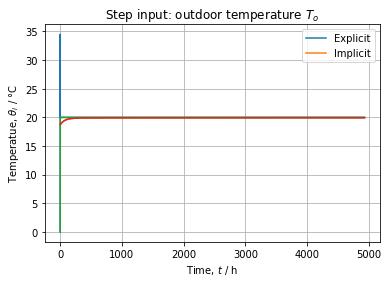

In [29]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')


# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])


u = np.zeros([13, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[1, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[4, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[5, :] = 10 * np.ones([1, n])    # To = 10 for n time steps

u[2, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
u[6, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

# pd.DataFrame(u)

n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
    
    
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()


### Analysis

We can't analyze the above curve because the tracing area is too large. We will therefore reduce the tracing area and the selected time step. Euler explicit gives us a numerically unstable result. However, this is not the case physically. We're now going to plot the same curves by reducing the time step and changing our scale. We obtain the following results: 


Time constants: 
 [2.08166121e+02 1.15620854e+03 1.59357522e+06 4.43956476e+06
 2.65021784e+05 7.50789518e+03] s 

2 x Time constants: 
 [4.16332241e+02 2.31241708e+03 3.18715043e+06 8.87912953e+06
 5.30043568e+05 1.50157904e+04] s 

Maximum time step: 416.33 s = 6.94 min
dt = 360.0 s = 6 min
4 * Time constants: 
 [     832     4624    30028  1060084  6374300 17758256] s 

Settling time: 4440 s = 74.0 min = 1.23 h = 0.05 days
Duration = 7200.0 s
Number of time steps = 20


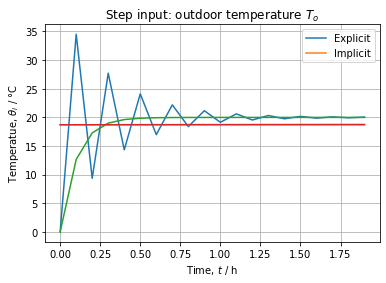

In [30]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')


# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 0.001 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])


u = np.zeros([13, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[1, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[4, :] = 10 * np.ones([1, n])    # To = 10 for n time steps
u[5, :] = 10 * np.ones([1, n])    # To = 10 for n time steps

u[2, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
u[3, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps
u[6, :] = 20 * np.ones([1, n])      # Tisp = 20 for n time steps

# pd.DataFrame(u)

n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])
    
    
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()


By reducing our scale and time step, we obtained the graph above. This time we can see that both responses stabilize at the set temperature of 20°C. These results validate our model and demonstrate the stability of our system. In conclusion, the explicit method seems the least interesting solution to use for this project.



### Simulate response to weather

In [77]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')


2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

In [78]:
filename = './FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data


From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m²,

from the start to the end date.

In [79]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]


##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

In [80]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)


The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [81]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)


##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [82]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)


##### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [83]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

α_wSW=0.2
τ_gSW=0.85
α_gSW=0.01

# input vector
To = data['To']
Ti = data['Ti']

Φo1 = α_wSW * 27 * data['Φtot']
Φo2 = α_wSW * 18 * data['Φtot']

Φa = α_gSW * 9 * data['Φtot']
#Φa = α_gSW * glass_surface_sun * data['Φtot']

Φi1 = τ_gSW * α_wSW * 27* data['Φtot']
Φi2 = τ_gSW * α_wSW * 18* data['Φtot']
Φi3 = τ_gSW * α_wSW * 9* data['Φtot'] #mur intérieur séparateur

Qa = data['Qa']

#Heat sources 0,8,10,11,18,20,21
u = pd.concat([Ti, Ti, To, To, Ti, Ti, To, Φo1, Φo2, Φi1, Φi2,Φi3, Φa], axis=1)
u.columns.values[[7, 8, 9, 10, 11, 12]] = ['Φo1', 'Φi1', 'Φi2','Φa', 'Φi3', 'Φo2']
# pd.DataFrame(u)



where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

AttributeError: 'Line2D' object has no property 'ylabel'

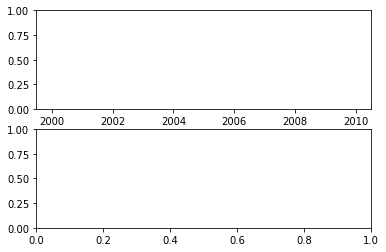

In [84]:
# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

#Initial conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#Time integration
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
data['θi_exp1'] = y_exp.T[:,0]
data['θi_exp2']=y_exp.T[:,1]
data['q_HVAC'] = q_HVAC.T

fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp1']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

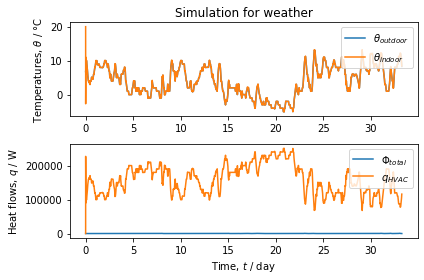

In [76]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()